# PREDICTING CUSTOMER CHURN

The goal of this study is to build machine learning models to predict the probability and show factors affecting customer churn.

A quick overview of the dataset.

- `CustomerID`: A unique identifier for each customer.
- `Name`: The name of the customer.
- `Age`: The age of the customer.
- `Gender`: The gender of the customer.
- `Location`: The location or city where the customer is based.
- `Email`: The email address of the customer.
- `Phone`: The phone number of the customer.
- `Address`: The postal address of the customer.
- `Segment`: The customer segment or category to which the customer belongs (e.g., Segment A, Segment B, Segment C).
- `PurchaseHistory`: A list of dictionaries representing the customer's purchase history. Each dictionary includes details about products purchased, purchase frequency, and purchase value.
    - `Product`: Product name.
    - `Frequency`: The number of times this product was purchased by the customer.
    - `Value`: Cost of  this product.
- `SubscriptionDetails`: A dictionary containing information about the customer's subscription plan, including the plan name, start date, and end date.
    - `Plan`: Name of the subscription plan.
    - `StartDate`: Start date of subscription plan.
    - `EndDate`: End date of subscription plan.
- `ServiceInteractions`: A list of dictionaries representing the customer's interactions with customer service. Each dictionary includes the type of interaction (e.g., Call, Email, Chat) and the date of the interaction.
    - `Type`: Type of service, it could be Call, Email or Chat.
    - `Date`: Date of the service interaction.
- `PaymentHistory`: A list of dictionaries representing the customer's payment history. Each dictionary includes the payment method (e.g., Credit Card, PayPal) and the number of late payments.
    - `Method`: Payment method, can either be Credit Card, PayPal or Bank Transfer.
    - `LatePayments`: Number of late payments.
- `WebsiteUsage`: A dictionary containing metrics related to the customer's usage of a website or app, including the number of page views and time spent (in minutes).
- `PageViews`: The number of website page views from the customer.
- `TimeSpent`: Time spent on the website by a customer in minutes.
- `ClickstreamData`: A list of dictionaries representing the customer's clickstream data, including actions such as clicks, searches, and adding items to the cart. Each dictionary includes the action type, the page where the action occurred, and a timestamp.
    - `Action`: Clickstream action of the user, could be Click, Search or Add to Cart.
    - `Page`: The website page in which the user performed this action.
    - `Timestamp`: Timestamp of the clickstream action.
- `EngagementMetrics`: A dictionary containing engagement metrics, such as the number of logins and the frequency of engagement (e.g., Daily, Weekly, Monthly).
    - `Logins`: The number of logins the user made.
    - `Frequency`: How often a customer logs in to the platform. Could be Daily, Weekly or Monthly.
- `Feedback`: Feedback provided by the customer, including a rating (e.g., 1 to 5) and a comment.
    - `Rating`: A value between 1 and 5 that indicates the customer’s feedback rating.
    - `Comment`: The comment left by the customer for the feedback.
- `MarketingCommunication`: A list of dictionaries representing the customer's history of marketing communication, including dates when emails were sent, opened, and clicked.
    - `EmailSent`: Date when email was sent.
    - `EmailOpened`: Date when email was opened.
    - `EmailClicked`: Date when email was clicked.
- `NPS`: The Net Promoter Score (NPS) of the customer, which measures customer loyalty and satisfaction on a scale of 0 to 10.
- `ChurnLabel`: A binary label indicating whether the customer has churned (1 for churn, 0 for no churn).
- `Timestamp`: The timestamp indicating when the data was recorded for the customer.

In [1]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import warnings
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, 
    ConfusionMatrixDisplay, 
    confusion_matrix,
    classification_report)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from ipywidgets import interact
import ipywidgets as widgets
import plotly.express as px

In [2]:
#suppressing the warnings
warnings.filterwarnings("ignore")

In [3]:
#investigation what the function does
literal_eval?

Signature: literal_eval(node_or_string)
Docstring:
Evaluate an expression node or a string containing only a Python
expression.  The string or node provided may only consist of the following
Python literal structures: strings, bytes, numbers, tuples, lists, dicts,
sets, booleans, and None.

Caution: A complex expression can overflow the C stack and cause a crash.
File:      c:\users\zbook g5\anaconda3\lib\ast.py
Type:      function

In [4]:
#Enabling pandas to show all the columns
pd.set_option("display.max_columns", None)

The whole Data Cleaning, feature engineering, extraction and transformation was done in this single `wrangle` function

In [5]:
def wrangle(filepath):
    df = pd.read_excel(filepath, index_col= "CustomerID")
    
    #dropping leaky and irrelevant columns
    drop_cols = []
    drop_cols.append(["Timestamp","Email", "Name", "Phone", "Address", "NPS"])
    df.drop(columns = drop_cols[0], inplace = True)
    nested_columns = [
    'PurchaseHistory',
    'SubscriptionDetails',
    'ServiceInteractions',
    'PaymentHistory',
    'WebsiteUsage',
    'ClickstreamData',
    'EngagementMetrics',
    'Feedback',
    'MarketingCommunication'
    ]
    for columns in df[nested_columns].columns:
        df[columns] = df[columns].apply(literal_eval)
    # From: PurchaseHistory
    # Extract:
    #   - PurchasedProducts: The names of all the products purchased by a user
    #   - PurchaseFrequency: The total number of times a user has made a purchase
    #   - PurchaseValue: The total cost of all the user's purchases
    df['PurchasedProducts'] = df['PurchaseHistory'].apply(lambda x: '|'.join([i['Product'] for i in x]))
    df['PurchaseFrequency'] = df['PurchaseHistory'].apply(lambda x: sum([i['Frequency'] for i in x]))
    df['PurchaseValue'] = df['PurchaseHistory'].apply(lambda x: sum([i['Value'] for i in x]))
    
    # From: SubscriptionDetails
    # Extract:
    #   - SubscriptionPlan: The plan name the user suscribed to
    #   - SubscriptionStartDate: The date the user started suscribing to the service
    #   - SubscriptionEndDate: The date the user stopped suscribing to the service
    #   - SubscriptionDuration: The duration through which the user suscribed to the service
    df['SubscriptionPlan'] = df['SubscriptionDetails'].apply(lambda x: x['Plan'])
    df['SubscriptionStartDate'] = df['SubscriptionDetails'].apply(lambda x: x['Start_Date'])
    df['SubscriptionEndDate'] = df['SubscriptionDetails'].apply(lambda x: x['End_Date'])
    df['SubscriptionDuration'] = (pd.to_datetime(df['SubscriptionEndDate']) - pd.to_datetime(df['SubscriptionStartDate'])).dt.days

    # From: WebsiteUsage
    # Extract:
    #   - WebsitePageViews: The number of times the user viewed the company's website
    #   - WebsiteTimeSpent: The total time the user spent on the company's website
    df['WebsitePageViews'] = df['WebsiteUsage'].apply(lambda x: x['PageViews'])
    df['WebsiteTimeSpent'] = df['WebsiteUsage'].apply(lambda x: x['TimeSpent(minutes)'])
    
    # From: EngagementMetrics
    # Extract:
    #   - EngagementMetricsLogins: The number of times the user logged in to the company's website
    #   - EngagementMetricsFrequency: How often a user logs in to the company's website
    df['EngagementMetricsLogins'] = df['EngagementMetrics'].apply(lambda x: x['Logins'])
    df['EngagementMetricsFrequency'] = df['EngagementMetrics'].apply(lambda x: x['Frequency'])
    
    # From: Feedback
    # Extract:
    #   - FeedbackRating: The feedback rating from the user
    #   - FeedbackComment: The feedback comment from the user
    df['FeedbackRating'] = df['Feedback'].apply(lambda x: x['Rating'])
    df['FeedbackComment'] = df['Feedback'].apply(lambda x: x['Comment'])
    
    # From: MarketingCommunication
    # Extract:
    #   - MarketingCommunicationNoOfEmails: The number of emails sent by the marketing team to the user
    #   - MarketingCommunicationOpenClickDiff: The duration between when the user opened the email, to when they actually clicked the links in the email
    #   - MarketingCommunicationSentOpenDiff: The duration between when the user was sent the email, to when they actually opened the email
    df['MarketingCommunicationNoOfEmails'] = df['MarketingCommunication'].apply(lambda x: len(x))
    df['MarketingCommunicationOpenClickDiff'] = df['MarketingCommunication'].apply(
        lambda x: np.mean([
            (pd.to_datetime(i['Email_Clicked']) \
             - pd.to_datetime(i['Email_Opened'])).days for i in x
            ]))
    df['MarketingCommunicationSentOpenDiff'] = df['MarketingCommunication'].apply(
        lambda x: np.mean([
            (pd.to_datetime(i['Email_Opened']) - pd.to_datetime(i['Email_Sent'])).days for i in x
            ]))
    # Get all unique ServiceInteractions 'Types'
    service_interaction_types = df['ServiceInteractions'].apply(lambda x: list(set([i['Type'] for i in x])))
    service_interaction_types = service_interaction_types.to_list()
    unique_service_interaction_type = []
    for i in service_interaction_types:
        unique_service_interaction_type.extend(i)
    unique_service_interaction_type = list(set(unique_service_interaction_type))
    print('All unique Service Interaction Types:', unique_service_interaction_type)
    
    # Get all unique PaymentHistory 'Method'
    payment_history_methods = df['PaymentHistory'].apply(lambda x: list(set([i['Method'] for i in x])))
    payment_history_methods = payment_history_methods.to_list()
    unique_payment_history_methods = []
    for i in payment_history_methods:
        unique_payment_history_methods.extend(i)
    unique_payment_history_methods = list(set(unique_payment_history_methods))
    print('All unique Payment History Methods:', unique_payment_history_methods)
    
    # Get all unique ClickstreamData 'Action'
    clickstream_data_actions = df['ClickstreamData'].apply(lambda x: list(set([i['Action'] for i in x])))
    clickstream_data_actions = clickstream_data_actions.to_list()
    unique_clickstream_data_actions = []
    for i in clickstream_data_actions:
        unique_clickstream_data_actions.extend(i)
    unique_clickstream_data_actions = list(set(unique_clickstream_data_actions))
    print('All unique Clickstream Data Actions:', unique_clickstream_data_actions)
    # From: ServiceInteractions
    # Extract: The number of service interactions made to customer service through Email, Call, and Chat.
    for usit in unique_service_interaction_type:
        df[f'ServiceInteractions_{usit}'] = df['ServiceInteractions'].apply(lambda x: len([i for i in x if i['Type'] == usit]))
    
    # From: PaymentHistory
    # Extract:
    #   - PaymentHistoryNoOfLatePayments: The total number of late payments made by the user
    #   - PaymentHistoryAvgNoOfLatePayments: The average number of late payments made by the user
    df['PaymentHistoryNoOfLatePayments'] = df['PaymentHistory'].apply(lambda x: sum([i['Late_Payments'] for i in x]))
    df['PaymentHistoryAvgNoOfLatePayments'] = df['PaymentHistory'].apply(lambda x: np.mean([i['Late_Payments'] for i in x]))
    
    # From: ClickstreamData
    # Extract: The number of ClickstreamData Actions performed by the user on the website, these include 'Add to Cart', 'Search' and 'Click'.
    for ucda in unique_clickstream_data_actions:
        df[f'ClickStreamData_{ucda}'] = df['ClickstreamData'].apply(lambda x: len([i for i in x if i['Action'] == ucda]))
    df.drop(columns = nested_columns, inplace  = True)
    #dropping another set of redundant and leaky columns
    df.drop(columns = ["PaymentHistoryNoOfLatePayments", #potential leaky column due to its corrrelation coefficient of 0.85
                       "PaymentHistoryAvgNoOfLatePayments", #potential leaky column due to its corrrelation coefficient of 0.85
                       "SubscriptionStartDate", # redundant column
                       "SubscriptionEndDate", #redundant column
                       "PurchasedProducts", #high cardinality column
                       'FeedbackComment'], #high cardinality column
                        inplace = True)
    return df

In [6]:
df = wrangle("Dataset.xlsx")
df.head()

All unique Service Interaction Types: ['Email', 'Chat', 'Call']
All unique Payment History Methods: ['PayPal', 'Credit Card', 'Bank Transfer']
All unique Clickstream Data Actions: ['Add to Cart', 'Click', 'Search']


Age  Gender      Location    Segment  ChurnLabel  \
CustomerID                                                     
1001         31    Male    Andrewfort  Segment B           1   
1002         66  Female   Millerhaven  Segment C           0   
1003         36  Female    Lozanostad  Segment B           0   
1004         62  Female  South Dustin  Segment C           1   
1005         68  Female    West James  Segment C           0   

            PurchaseFrequency  PurchaseValue SubscriptionPlan  \
CustomerID                                                      
1001                       38        3994.72          Express   
1002                        4        2844.35              Pro   
1003                       14        1866.52        Essential   
1004                       28        1378.64            Smart   
1005                       39        2425.05            Basic   

            SubscriptionDuration  WebsitePageViews  WebsiteTimeSpent  \
CustomerID                                                             
1001                         871                49                15   
1002                         290               100                 9   
1003                         319                 1                97   
1004                         803                25                31   
1005                         580                77                51   

            EngagementMetricsLogins EngagementMetricsFrequency  \
CustomerID                                                       
1001                             19                     Weekly   
1002                              9                     Weekly   
1003                             19                    Monthly   
1004                              4                      Daily   
1005                             12                     Weekly   

            FeedbackRating  MarketingCommunicationNoOfEmails  \
CustomerID                                                     
1001                     1                                 8   
1002                     2                                 9   
1003                     4                                 8   
1004                     1                                10   
1005                     3                                 7   

            MarketingCommunicationOpenClickDiff  \
CustomerID                                        
1001                                      319.0   
1002                                       88.0   
1003                                      117.0   
1004                                      423.0   
1005                                       96.0   

            MarketingCommunicationSentOpenDiff  ServiceInteractions_Email  \
CustomerID                                                                  
1001                                     818.0                          1   
1002                                     110.0                         10   
1003                                     333.0                          1   
1004                                     159.0                         18   
1005                                     193.0                          5   

            ServiceInteractions_Chat  ServiceInteractions_Call  \
CustomerID                                                       
1001                               2                         1   
1002                               4                         5   
1003                               1                         1   
1004                              24                        17   
1005                               1                         4   

            ClickStreamData_Add to Cart  ClickStreamData_Click  \
CustomerID                                                       
1001                                  8                      4   
1002                                  8                      9   
1003                                  2                      3   

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12483 entries, 1001 to 13483
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Age                                  12483 non-null  int64  
 1   Gender                               12483 non-null  object 
 2   Location                             12483 non-null  object 
 3   Segment                              12483 non-null  object 
 4   ChurnLabel                           12483 non-null  int64  
 5   PurchaseFrequency                    12483 non-null  int64  
 6   PurchaseValue                        12483 non-null  float64
 7   SubscriptionPlan                     12483 non-null  object 
 8   SubscriptionDuration                 12483 non-null  int64  
 9   WebsitePageViews                     12483 non-null  int64  
 10  WebsiteTimeSpent                     12483 non-null  int64  
 11  EngagementMetricsLogins       

In [8]:
df.select_dtypes("object").nunique()

Gender                           2
Location                      9255
Segment                          3
SubscriptionPlan                20
EngagementMetricsFrequency       3
dtype: int64

ChurnLabel
1    0.505808
0    0.494192
Name: proportion, dtype: float64


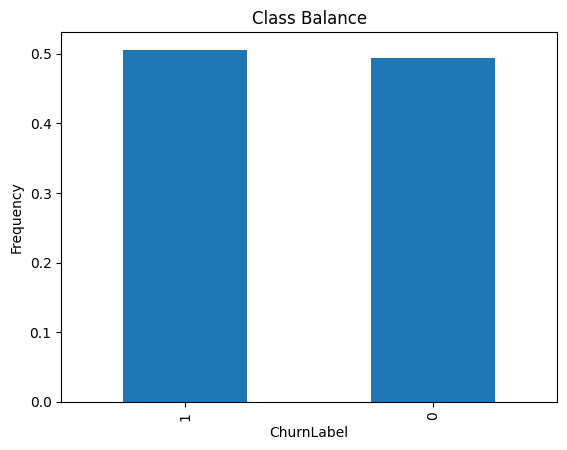

In [9]:
df["ChurnLabel"].value_counts(normalize = True).plot(kind = "bar")
plt.ylabel("Frequency")
plt.title("Class Balance")
print(df["ChurnLabel"].value_counts(normalize = True))

In [10]:
class_balance = df["ChurnLabel"].value_counts(normalize = True).to_frame().reset_index()
class_balance

ChurnLabel  proportion
0           1    0.505808
1           0    0.494192

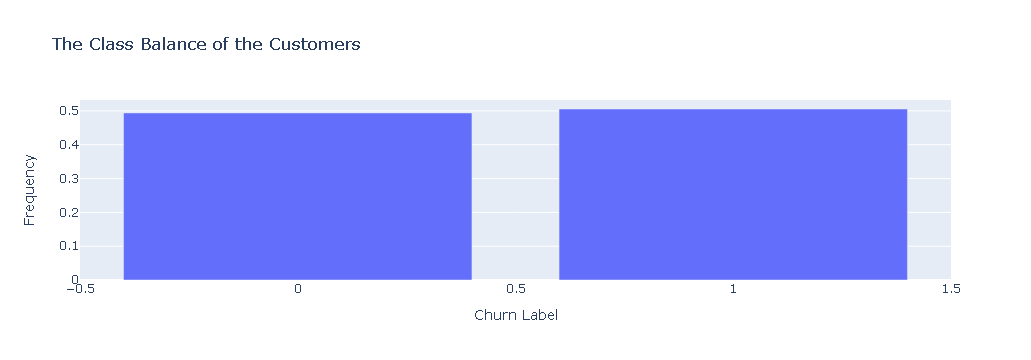

In [11]:
#using plotly
fig = px.bar(x = class_balance["ChurnLabel"], 
             y = class_balance["proportion"],
             title = "The Class Balance of the Customers")
fig.update_layout(xaxis_title = "Churn Label", yaxis_title = "Frequency")
fig.show()

The class balance appears roughly even, as both bars for the "Churn Label" (0 and 1) are of similar height, indicating an equal or near-equal distribution of the two classes.

In [12]:
majority_class_prop, minority_class_prop = df["ChurnLabel"].value_counts(normalize=True)

In [13]:
majority_class_prop

0.5058078987422895

In [14]:
df["SubscriptionPlan"].value_counts()

SubscriptionPlan
Basic        680
Student      661
Essential    656
Unlimited    653
Bronze       649
Plus         647
Silver       646
Select       629
Gold         622
Prime        620
Eco          615
Flex         614
Deluxe       614
Smart        613
Pro          610
VIP          609
Express      593
Family       593
Trial        585
Elite        574
Name: count, dtype: int64

In [15]:
segment_pivot = pd.pivot_table(df, 
                               index = "Segment",
                               values = "ChurnLabel", 
                               aggfunc= np.mean).sort_values(by = "ChurnLabel")
segment_pivot

ChurnLabel
Segment              
Segment B    0.500121
Segment C    0.505597
Segment A    0.511667

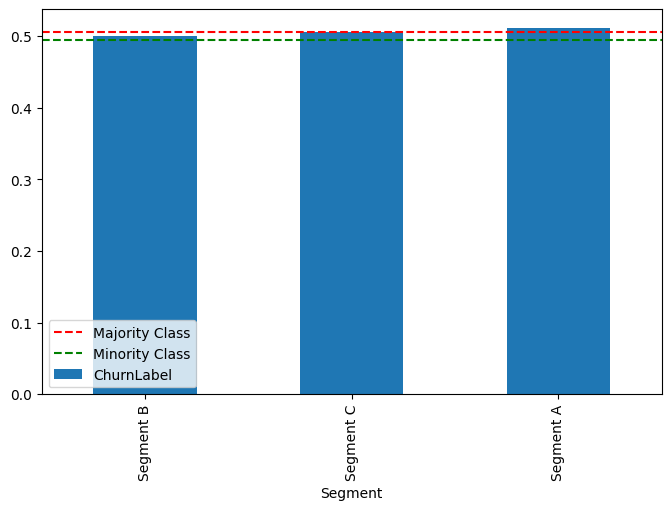

In [16]:
fig, ax = plt.subplots(figsize = (8, 5))
segment_pivot.plot(kind = "bar", ax = ax, legend = False)
plt.axhline(
    majority_class_prop, linestyle = "--", color = "red", label = "Majority Class"
)
plt.axhline(
    minority_class_prop, linestyle = "--", color = "green", label = "Minority Class"
)
plt.legend()

This bar graph shows the proportions of the "ChurnLabel" across segments (e.g., Segment A, B, C). The red dashed line indicates the majority class proportion, while the green dashed line shows the minority class proportion. All segments seem balanced near the 0.5 proportion mark.
Segment A may have a higher likelihood of churn despite overall class balance. 

In [17]:
subscription_plan_pivot = pd.pivot_table(df, 
                                         index = "SubscriptionPlan",
                                         values = "ChurnLabel", 
                                         aggfunc= np.mean).sort_values(by = "ChurnLabel")
subscription_plan_pivot

ChurnLabel
SubscriptionPlan            
Pro                 0.477049
Family              0.482293
Express             0.485666
Basic               0.486765
Bronze              0.491525
Deluxe              0.493485
VIP                 0.494253
Smart               0.495922
Silver              0.501548
Elite               0.501742
Plus                0.503864
Select              0.505564
Eco                 0.505691
Trial               0.505983
Gold                0.509646
Unlimited           0.517611
Student             0.521936
Essential           0.528963
Prime               0.537097
Flex                0.566775

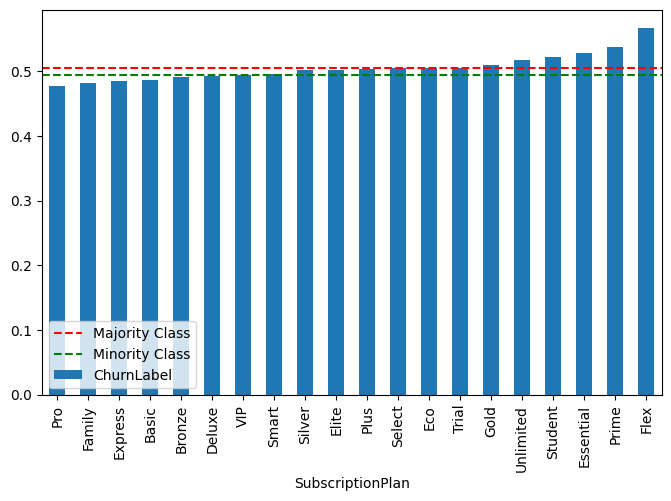

In [18]:
fig, ax = plt.subplots(figsize = (8, 5))
subscription_plan_pivot.plot(kind = "bar", ax = ax, legend = False)
plt.axhline(
    majority_class_prop, linestyle = "--", color = "red", label = "Majority Class"
)
plt.axhline(
    minority_class_prop, linestyle = "--", color = "green", label = "Minority Class"
)
plt.legend()

Observing the chart, it appears that Flex, Prime, Unlimited, Essential, and Student categories have higher churn rates compared to other segments.

In [19]:
#lets know if there is any correlation between the `Location` and the `ChurnLabel`
#lets do a chi-square test 
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df["Location"], df["ChurnLabel"])
chi2, p, dof, expected = chi2_contingency(contingency_table)

if p< 0.05:
    print("There is a significant relationship")
else:
    print("There is no significant relationship")
#looks like we have to drop location

There is no significant relationship


In [20]:
df.drop(columns = "Location", inplace =True)

In [21]:
df.columns

Index(['Age', 'Gender', 'Segment', 'ChurnLabel', 'PurchaseFrequency',
       'PurchaseValue', 'SubscriptionPlan', 'SubscriptionDuration',
       'WebsitePageViews', 'WebsiteTimeSpent', 'EngagementMetricsLogins',
       'EngagementMetricsFrequency', 'FeedbackRating',
       'MarketingCommunicationNoOfEmails',
       'MarketingCommunicationOpenClickDiff',
       'MarketingCommunicationSentOpenDiff', 'ServiceInteractions_Email',
       'ServiceInteractions_Chat', 'ServiceInteractions_Call',
       'ClickStreamData_Add to Cart', 'ClickStreamData_Click',
       'ClickStreamData_Search'],
      dtype='object')

In [22]:
#splitting
target = "ChurnLabel"
X = df.drop(columns = target)
y = df[target]

In [23]:
#horizontal splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, test_size= 0.2)

In [24]:
#Baseline model
acc_baseline = y_train.value_counts(normalize = True).max()
round(acc_baseline, 3)

0.509

In [25]:

#create model
model_lo = make_pipeline(OneHotEncoder(use_cat_names= True), LogisticRegression(max_iter= 1000))
#fitting our model
model_lo.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Gender', 'Segment', 'SubscriptionPlan',
                                     'EngagementMetricsFrequency'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [26]:
#let's evaluate our model
acc_train = accuracy_score(y_train, model_lo.predict(X_train))
acc_test = accuracy_score(y_test, model_lo.predict(X_test))
print(f"Training accuracy score is {round(acc_train, 3)} and test accuracy score is {round(acc_test, 3)}")

Training accuracy score is 0.825 and test accuracy score is 0.821


In [27]:
#let's show what are model is trying to tell us
features = model_lo.named_steps["onehotencoder"].get_feature_names()
features

array(['Age', 'Gender_Male', 'Gender_Female', 'Segment_Segment A',
       'Segment_Segment B', 'Segment_Segment C', 'PurchaseFrequency',
       'PurchaseValue', 'SubscriptionPlan_Essential',
       'SubscriptionPlan_Gold', 'SubscriptionPlan_Basic',
       'SubscriptionPlan_Unlimited', 'SubscriptionPlan_Plus',
       'SubscriptionPlan_Elite', 'SubscriptionPlan_Bronze',
       'SubscriptionPlan_Pro', 'SubscriptionPlan_Express',
       'SubscriptionPlan_Flex', 'SubscriptionPlan_Prime',
       'SubscriptionPlan_Trial', 'SubscriptionPlan_Student',
       'SubscriptionPlan_Deluxe', 'SubscriptionPlan_Family',
       'SubscriptionPlan_VIP', 'SubscriptionPlan_Smart',
       'SubscriptionPlan_Eco', 'SubscriptionPlan_Select',
       'SubscriptionPlan_Silver', 'SubscriptionDuration',
       'WebsitePageViews', 'WebsiteTimeSpent', 'EngagementMetricsLogins',
       'EngagementMetricsFrequency_Monthly',
       'EngagementMetricsFrequency_Daily',
       'EngagementMetricsFrequency_Weekly', 'FeedbackRa

In [28]:
importances = model_lo.named_steps["logisticregression"].coef_[0]
importances

array([ 3.05369142e-03, -1.17311004e-03, -5.97402185e-02, -1.65922035e-02,
       -5.12783409e-02,  6.95721587e-03,  1.35886785e-03, -2.83910917e-05,
        7.14390957e-02, -1.64316578e-02, -4.82917500e-02, -2.87599857e-02,
        7.40647276e-02,  3.24522791e-02, -7.00608164e-02, -7.77584303e-02,
        2.87642730e-02, -5.84795593e-03,  7.45139545e-02, -5.62658785e-02,
       -5.84423362e-02, -4.50753912e-02,  5.05980632e-02,  3.77733668e-02,
        1.65081708e-02,  3.60369305e-02, -1.80419566e-02, -5.80880311e-02,
        1.91162374e-04, -2.01747852e-03, -5.96357774e-02, -5.23645116e-03,
       -1.07760670e-01,  7.62802507e-02, -2.94329094e-02,  3.79600426e-02,
       -1.40387629e-02,  2.96977044e-05, -8.78345651e-05,  9.27445588e-02,
        1.01580572e-01,  1.31893723e-01,  1.52377145e-03,  8.50705027e-04,
        8.19612136e-03])

In [29]:
odds_ratio = pd.Series(np.exp(importances), index = features).sort_values()
odds_ratio

EngagementMetricsFrequency_Monthly     0.897842
SubscriptionPlan_Pro                   0.925188
SubscriptionPlan_Bronze                0.932337
Gender_Female                          0.942009
WebsiteTimeSpent                       0.942108
SubscriptionPlan_Student               0.943233
SubscriptionPlan_Silver                0.943567
SubscriptionPlan_Trial                 0.945288
Segment_Segment B                      0.950014
SubscriptionPlan_Basic                 0.952856
SubscriptionPlan_Deluxe                0.955925
EngagementMetricsFrequency_Weekly      0.970996
SubscriptionPlan_Unlimited             0.971650
SubscriptionPlan_Select                0.982120
Segment_Segment A                      0.983545
SubscriptionPlan_Gold                  0.983703
MarketingCommunicationNoOfEmails       0.986059
SubscriptionPlan_Flex                  0.994169
EngagementMetricsLogins                0.994777
WebsitePageViews                       0.997985
Gender_Male                            0

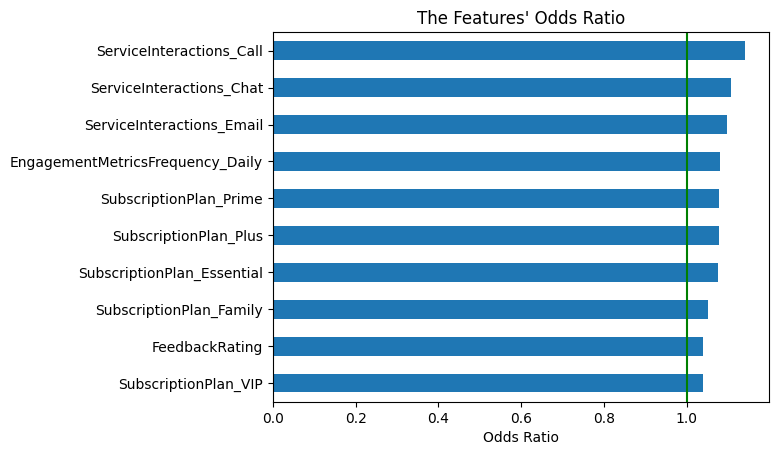

In [30]:
odds_ratio.tail(10).plot(kind = "barh", xlabel = "Odds Ratio", title = "The Features' Odds Ratio")
plt.axvline(x = 1, color = "green")

ServiceInteractions_Call, Chat, and Email have high odds ratios, meaning frequent interactions with support services are strongly associated with higher churn likelihood. This could indicate dissatisfaction or unresolved issues. All the other features have no impact on the odds of customers churning.













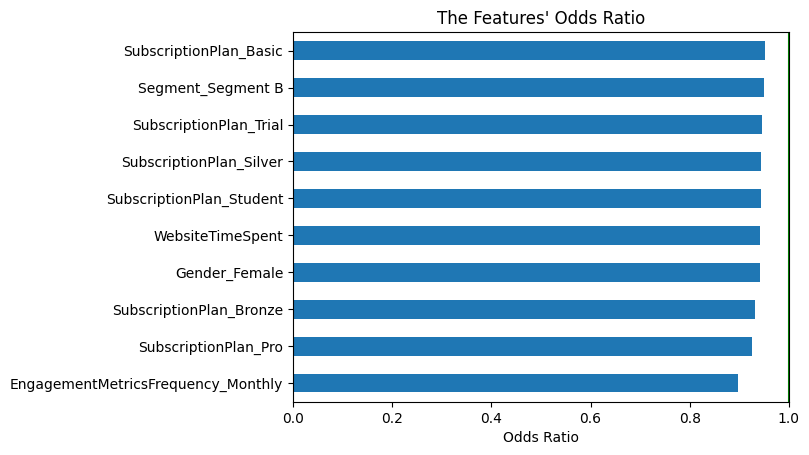

In [31]:
odds_ratio.head(10).plot(kind = "barh", xlabel = "Odds Ratio", title = "The Features' Odds Ratio")
plt.axvline(x = 1, color = "green")

1. WebsiteTimeSpent (Odds Ratio < 1 or about 0.94): Customers who spend more time on the website are less likely to churn, possibly indicating better engagement or satisfaction.
2. MarketingCommunacationNoOfEmails has an odds ratio < 1 which suggests that customers receiving more emails are less likely to churn, provided the content of emails is relevant and engaging.

In [32]:
df.select_dtypes("object").nunique()

Gender                         2
Segment                        3
SubscriptionPlan              20
EngagementMetricsFrequency     3
dtype: int64

In [33]:
#let's us invoke decision trees
model_dt = make_pipeline(OrdinalEncoder(), DecisionTreeClassifier(random_state= 42)) #one-hot encoder leads to imbalanced trees
model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Gender', 'Segment', 'SubscriptionPlan',
                                      'EngagementMetricsFrequency'],
                                mapping=[{'col': 'Gender',
                                          'data_type': dtype('O'),
                                          'mapping': Male      1
Female    2
NaN      -2
dtype: int64},
                                         {'col': 'Segment',
                                          'data_type': dtype('O'),
                                          'mapping': Segment A    1
Segment B    2
Segment C    3
NaN         -2
dtype: int64},
                                         {'col': 'SubscriptionPlan',
                                          'data_type': dtype('O'),
                                          'mapping': Essential     1
Gold          2
Basic         3
Unlimited     4
Plus          5
Elite         6
Bronze        7
Pro           8
Express       9
Flex         10
Prime        11
Trial        12
Student      13
Deluxe       14
Family       15
VIP          16
Smart        17
Eco          18
Select       19
Silver       20
NaN          -2
dtype: int64},
                                         {'col': 'EngagementMetricsFrequency',
                                          'data_type': dtype('O'),
                                          'mapping': Monthly    1
Daily      2
Weekly     3
NaN       -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [34]:
acc_train_d = accuracy_score(y_train, model_dt.predict(X_train))
acc_test_d = model_dt.score(X_test, y_test)
print(acc_train_d)
print(acc_test_d)

1.0
0.7977573087705246


In [35]:
model_dt.named_steps["decisiontreeclassifier"].get_depth() #the depth of the tree

25

In [36]:
tree_params = range(1, 25, 2)

In [37]:
#let's tune the number of depths in the tree
train_acc = []
test_acc = []
for d in tree_params:
    test_model_dt = make_pipeline(OrdinalEncoder(), 
                                  DecisionTreeClassifier(max_depth= d,
                                                         random_state= 42)
                                 )
    test_model_dt.fit(X_train, y_train)
    #append to both the `train_acc` and the `test_acc`
    train_acc.append(test_model_dt.score(X_train, y_train))
    test_acc.append(test_model_dt.score(X_test, y_test))
print(train_acc)
print(test_acc)

[0.8173442819947927, 0.8185459643500901, 0.8322651712397356, 0.8436811536150611, 0.8628079311035449, 0.8892449429200882, 0.9158822351291809, 0.9400160224314039, 0.964650510715001, 0.9837772882034849, 0.994892849989986, 0.9990987382335269]
[0.8089707649179014, 0.8109731678013616, 0.8129755706848217, 0.8089707649179014, 0.802563075690829, 0.8077693231878253, 0.801762114537445, 0.802963556267521, 0.7993592310772928, 0.7973568281938326, 0.7969563476171405, 0.8041649979975971]


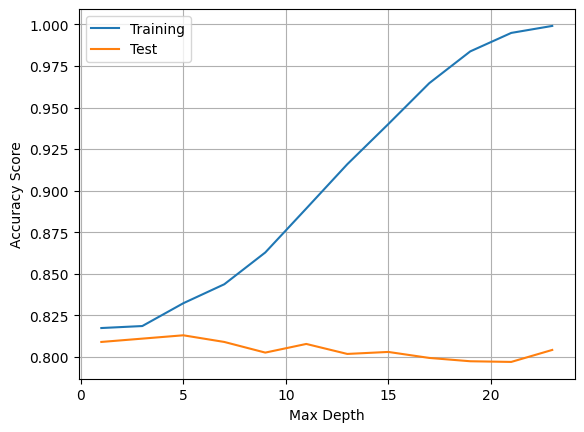

In [38]:
plt.plot(tree_params, train_acc, label = "Training")
plt.plot(tree_params, test_acc, label = "Test")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.grid()
plt.legend()

our best max_depth is 5

In [39]:
final_model_dt = make_pipeline(
    OrdinalEncoder(), DecisionTreeClassifier(max_depth= 5, random_state= 42)
)
final_model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Gender', 'Segment', 'SubscriptionPlan',
                                      'EngagementMetricsFrequency'],
                                mapping=[{'col': 'Gender',
                                          'data_type': dtype('O'),
                                          'mapping': Male      1
Female    2
NaN      -2
dtype: int64},
                                         {'col': 'Segment',
                                          'data_type': dtype('O'),
                                          'mapping': Segment A    1
Segment B    2
Segment C    3
NaN         -2
dtype: int64},
                                         {'col': 'SubscriptionPlan',
                                          'data_type': dtype(...
                                          'mapping': Essential     1
Gold          2
Basic         3
Unlimited     4
Plus          5
Elite         6
Bronze        7
Pro           8
Express       9
Flex         10
Prime        11
Trial        12
Student      13
Deluxe       14
Family       15
VIP          16
Smart        17
Eco          18
Select       19
Silver       20
NaN          -2
dtype: int64},
                                         {'col': 'EngagementMetricsFrequency',
                                          'data_type': dtype('O'),
                                          'mapping': Monthly    1
Daily      2
Weekly     3
NaN       -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, random_state=42))])

In [40]:
new_acc_train = final_model_dt.score(X_train, y_train)
new_acc_test = final_model_dt.score(X_test, y_test)
print(f" New Training Accuracy score is {round(new_acc_train, 3)} and New test Accuracy score is {round(new_acc_test, 3)}")

 New Training Accuracy score is 0.832 and New test Accuracy score is 0.813


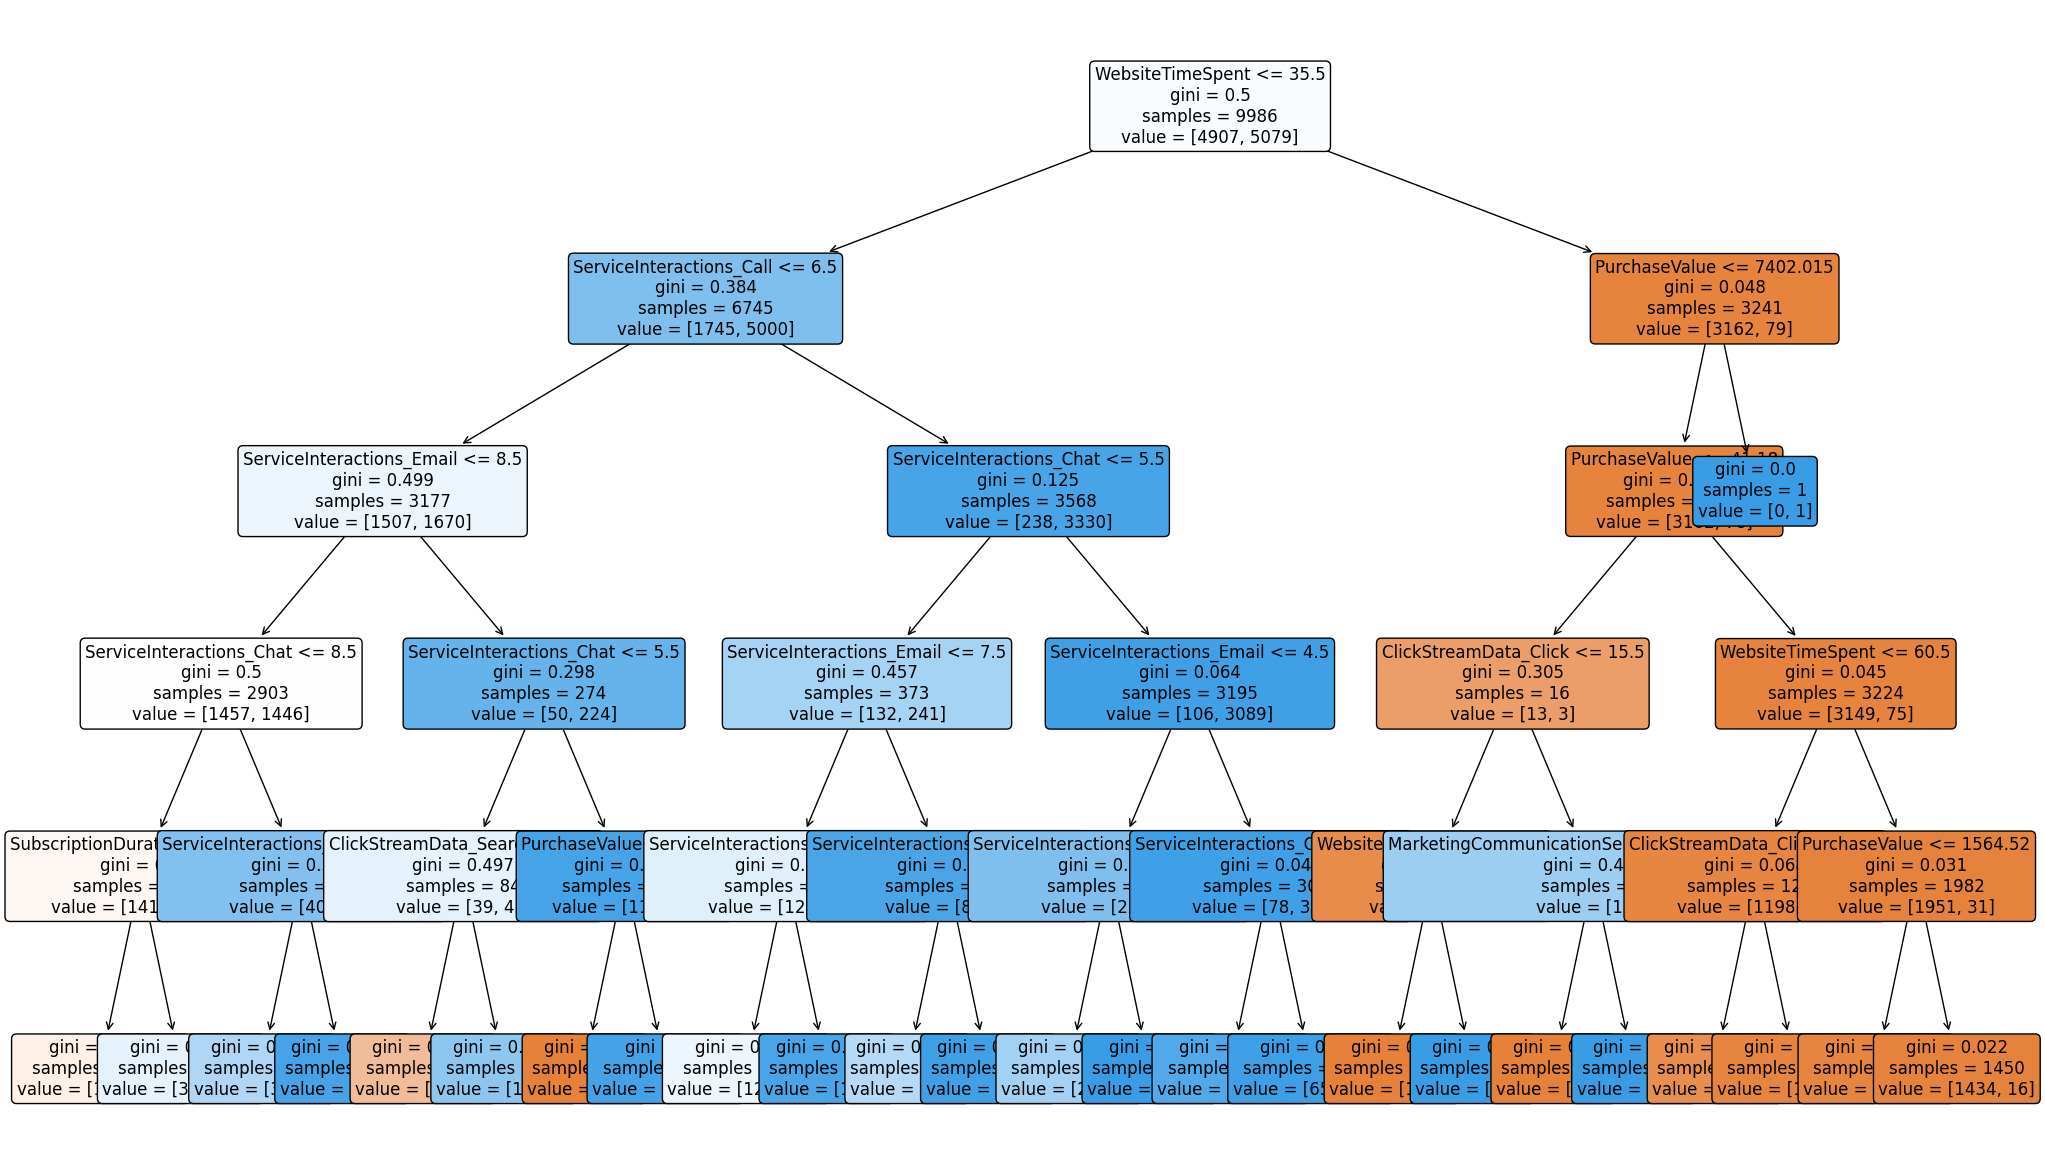

In [41]:
fig, ax = plt.subplots(figsize = (25, 15))
#lats plot the tree
plot_tree(
    decision_tree= final_model_dt.named_steps["decisiontreeclassifier"],
    feature_names= list(X_train.columns),
    rounded = True,
    filled= True,
    max_depth= 5,
    fontsize= 12,
    ax = ax
)
plt.show()

In [42]:
features_dt = model_dt.named_steps["ordinalencoder"].get_feature_names()
len(features_dt)

21

In [43]:
len(X_train.columns)

21

In [44]:
coefficients = model_dt.named_steps["decisiontreeclassifier"].feature_importances_
coefficients

array([0.02090654, 0.00293015, 0.00629773, 0.0225669 , 0.02263734,
       0.02186341, 0.03867922, 0.02981831, 0.47334803, 0.02073221,
       0.00423765, 0.01153432, 0.01515329, 0.02968132, 0.03604636,
       0.03322345, 0.037026  , 0.1270297 , 0.0163489 , 0.01252573,
       0.01741342])

In [45]:
feat_imp_dt = pd.Series(coefficients, index = features_dt)
feat_imp_dt

Age                                    0.020907
Gender                                 0.002930
Segment                                0.006298
PurchaseFrequency                      0.022567
PurchaseValue                          0.022637
SubscriptionPlan                       0.021863
SubscriptionDuration                   0.038679
WebsitePageViews                       0.029818
WebsiteTimeSpent                       0.473348
EngagementMetricsLogins                0.020732
EngagementMetricsFrequency             0.004238
FeedbackRating                         0.011534
MarketingCommunicationNoOfEmails       0.015153
MarketingCommunicationOpenClickDiff    0.029681
MarketingCommunicationSentOpenDiff     0.036046
ServiceInteractions_Email              0.033223
ServiceInteractions_Chat               0.037026
ServiceInteractions_Call               0.127030
ClickStreamData_Add to Cart            0.016349
ClickStreamData_Click                  0.012526
ClickStreamData_Search                 0

<Axes: title={'center': 'Feature Importance for the Decision Tree'}, xlabel='Gini Importance', ylabel='Features'>

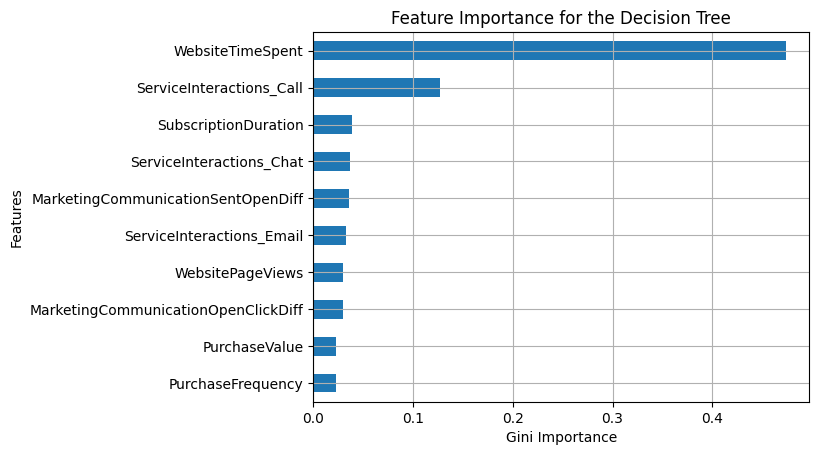

In [46]:
feat_imp_dt.sort_values().tail(10).plot(kind = "barh", 
                               xlabel = "Gini Importance", 
                               ylabel = "Features",
                               title = "Feature Importance for the Decision Tree",
                               grid = True)

In [47]:
#let's look at randomforest classifier
clf = make_pipeline(OrdinalEncoder(), 
                    RandomForestClassifier(random_state= 42))
clf

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [48]:
#let's try some hyperparameter tuning
params = {
    "randomforestclassifier__n_estimators": range(25,100,25),
    "randomforestclassifier__max_depth": range(4, 100, 5)
}
params

{'randomforestclassifier__n_estimators': range(25, 100, 25),
 'randomforestclassifier__max_depth': range(4, 100, 5)}

In [49]:
#let's perform a grid search
model = GridSearchCV(
    clf,
    param_grid= params,
    cv = 5,
    n_jobs= -1,
    verbose= 1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(4, 100, 5),
                         'randomforestclassifier__n_estimators': range(25, 100, 25)},
             verbose=1)

In [50]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(4, 100, 5),
                         'randomforestclassifier__n_estimators': range(25, 100, 25)},
             verbose=1)

In [51]:
pd.DataFrame(model.cv_results_).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.464483      0.014369         0.031255        0.000008   
1       0.796357      0.022359         0.040799        0.012380   
2       1.130435      0.015968         0.048447        0.007996   
3       0.727687      0.051122         0.035772        0.006290   
4       1.540694      0.085063         0.075352        0.006212   

  param_randomforestclassifier__max_depth  \
0                                       4   
1                                       4   
2                                       4   
3                                       9   
4                                       9   

  param_randomforestclassifier__n_estimators  \
0                                         25   
1                                         50   
2                                         75   
3                                         25   
4                                         50   

                                              params  split0_test_score  \
0  {'randomforestclassifier__max_depth': 4, 'rand...           0.834835   
1  {'randomforestclassifier__max_depth': 4, 'rand...           0.830831   
2  {'randomforestclassifier__max_depth': 4, 'rand...           0.831832   
3  {'randomforestclassifier__max_depth': 9, 'rand...           0.829830   
4  {'randomforestclassifier__max_depth': 9, 'rand...           0.825325   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.811217           0.826740           0.825739           0.827742   
1           0.811718           0.824236           0.827241           0.827742   
2           0.809214           0.826239           0.823736           0.829244   
3           0.811217           0.823736           0.826239           0.825238   
4           0.812218           0.822734           0.824236           0.825238   

   mean_test_score  std_test_score  rank_test_score  
0         0.825254        0.007713                1  
1         0.824353        0.006655                2  
2         0.824053        0.007906                3  
3         0.823252        0.006344                4  
4         0.821950        0.004955                5

In [52]:
model.best_estimator_

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Gender', 'Segment', 'SubscriptionPlan',
                                      'EngagementMetricsFrequency'],
                                mapping=[{'col': 'Gender',
                                          'data_type': dtype('O'),
                                          'mapping': Male      1
Female    2
NaN      -2
dtype: int64},
                                         {'col': 'Segment',
                                          'data_type': dtype('O'),
                                          'mapping': Segment A    1
Segment B    2
Segment C    3
NaN         -2
dtype: int64},
                                         {'col': 'SubscriptionPlan',
                                          'data_type': dtype(...
Gold          2
Basic         3
Unlimited     4
Plus          5
Elite         6
Bronze        7
Pro           8
Express       9
Flex         10
Prime        11
Trial        12
Student      13
Deluxe       14
Family       15
VIP          16
Smart        17
Eco          18
Select       19
Silver       20
NaN          -2
dtype: int64},
                                         {'col': 'EngagementMetricsFrequency',
                                          'data_type': dtype('O'),
                                          'mapping': Monthly    1
Daily      2
Weekly     3
NaN       -2
dtype: int64}])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=4, n_estimators=25,
                                        random_state=42))])

In [53]:
acc_train_rf = model.best_estimator_.score(X_train, y_train)
acc_test_rf = model.best_estimator_.score(X_test, y_test)
print(f"Training acc_score is {acc_train_rf} and test_score is {acc_test_rf}")

Training acc_score is 0.8267574604446225 and test_score is 0.8241890268321986


<Axes: >

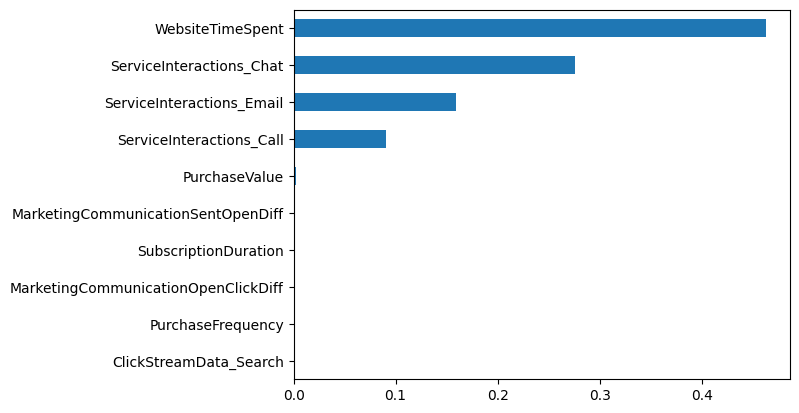

In [54]:
features_rf = X_train.columns
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
feat_imp_rf = pd.Series(importances, index = features_rf)
feat_imp_rf.sort_values().tail(10).plot(kind = "barh")

In [55]:
clf_gb = make_pipeline(OrdinalEncoder(), GradientBoostingClassifier())
clf_gb

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [56]:
params_gb = {
    "gradientboostingclassifier__n_estimators":range(25, 100, 25),
    "gradientboostingclassifier__max_depth":range(4, 100, 5)
}

In [57]:
model_gb = GridSearchCV(clf_gb, param_grid= params_gb, cv = 5, n_jobs= -1, verbose= 1 )
model_gb

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(4, 100, 5),
                         'gradientboostingclassifier__n_estimators': range(25, 100, 25)},
             verbose=1)

In [58]:
model_gb.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(4, 100, 5),
                         'gradientboostingclassifier__n_estimators': range(25, 100, 25)},
             verbose=1)

In [59]:
acc_train_gb = model_gb.score(X_train, y_train)
acc_test_gb = model_gb.score(X_test, y_test)

print("Training Accuracy:", round(acc_train_gb, 4))
print("Validation Accuracy:", round(acc_test_gb, 4))

Training Accuracy: 0.9571
Validation Accuracy: 0.8142


In [60]:
model_gb.best_params_

{'gradientboostingclassifier__max_depth': 9,
 'gradientboostingclassifier__n_estimators': 25}

<Axes: >

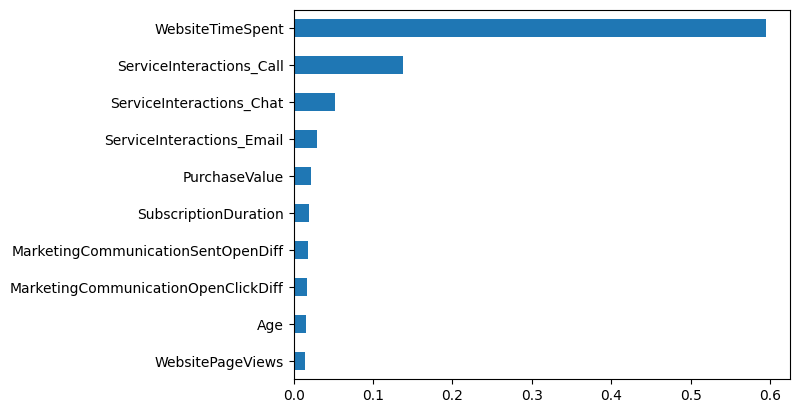

In [61]:
importances_gb = (model_gb.best_estimator_
                  .named_steps["gradientboostingclassifier"]
                  .feature_importances_)
feat_gb = model_gb.best_estimator_.named_steps["ordinalencoder"].get_feature_names()
feat_imp_gb = pd.Series(importances_gb, index = feat_gb)
feat_imp_gb.sort_values().tail(10).plot(kind = "barh")

In [62]:
#classification report for graident boosting
print(classification_report(y_test, model_gb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1262
           1       0.81      0.81      0.81      1235

    accuracy                           0.81      2497
   macro avg       0.81      0.81      0.81      2497
weighted avg       0.81      0.81      0.81      2497



In [63]:
#classification report for decision tree
print(classification_report(y_test, model_dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1262
           1       0.80      0.79      0.79      1235

    accuracy                           0.80      2497
   macro avg       0.80      0.80      0.80      2497
weighted avg       0.80      0.80      0.80      2497



In [64]:
#classification report for logistic regression
print(classification_report(y_test, model_lo.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1262
           1       0.81      0.83      0.82      1235

    accuracy                           0.82      2497
   macro avg       0.82      0.82      0.82      2497
weighted avg       0.82      0.82      0.82      2497



In [65]:
#classification report for random forest
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84      1262
           1       0.90      0.73      0.80      1235

    accuracy                           0.82      2497
   macro avg       0.84      0.82      0.82      2497
weighted avg       0.84      0.82      0.82      2497



| Model              | Accuracy | Precision (Class 1) | Recall (Class 1) | F1-Score (Class 1) | False Negatives | False Positives 
|--------------------|----------|---------------------|------------------|--------------------|-----------------|-----------------|
| Logistic Regression | 82%      | 0.81                | 0.83             | 0.82               | 210              | 233              |
| Random Forest       | 82%      | 0.90                | 0.72             | 0.80               | 345              | 97              |
| Gradient Boosting   | 81%      | 0.81                | 0.81             | 0.81               | 234              | 231              |
| Decision Tree       | 80%      | 0.81                | 0.79             | 0.80               | 257              | 235              |


Comparing all the algorithms
1. Logistic Regression:
Best recall for churners (0.83) among all models.
Well-balanced precision and recall for churners, making it suitable when minimizing false negatives (i.e., catching churners) is critical.

2. Random Forest:
Highest precision for churners (0.90), meaning it’s very confident when identifying churners, but it sacrifices recall (0.72). This model is better when false positives are more expensive (e.g., retention campaigns cost a lot).

3. Gradient Boosting:
Balanced precision and recall for churners (0.81 each). A middle-ground option when you value a balance between false positives and false negatives.

4. Decision Tree:
Performs slightly worse than Gradient Boosting and Logistic Regression. It has lower recall for churners (0.79) and overall accuracy.

Text(0.5, 1.0, 'Confusion Matrix for the Gradient Boosting Classifier')

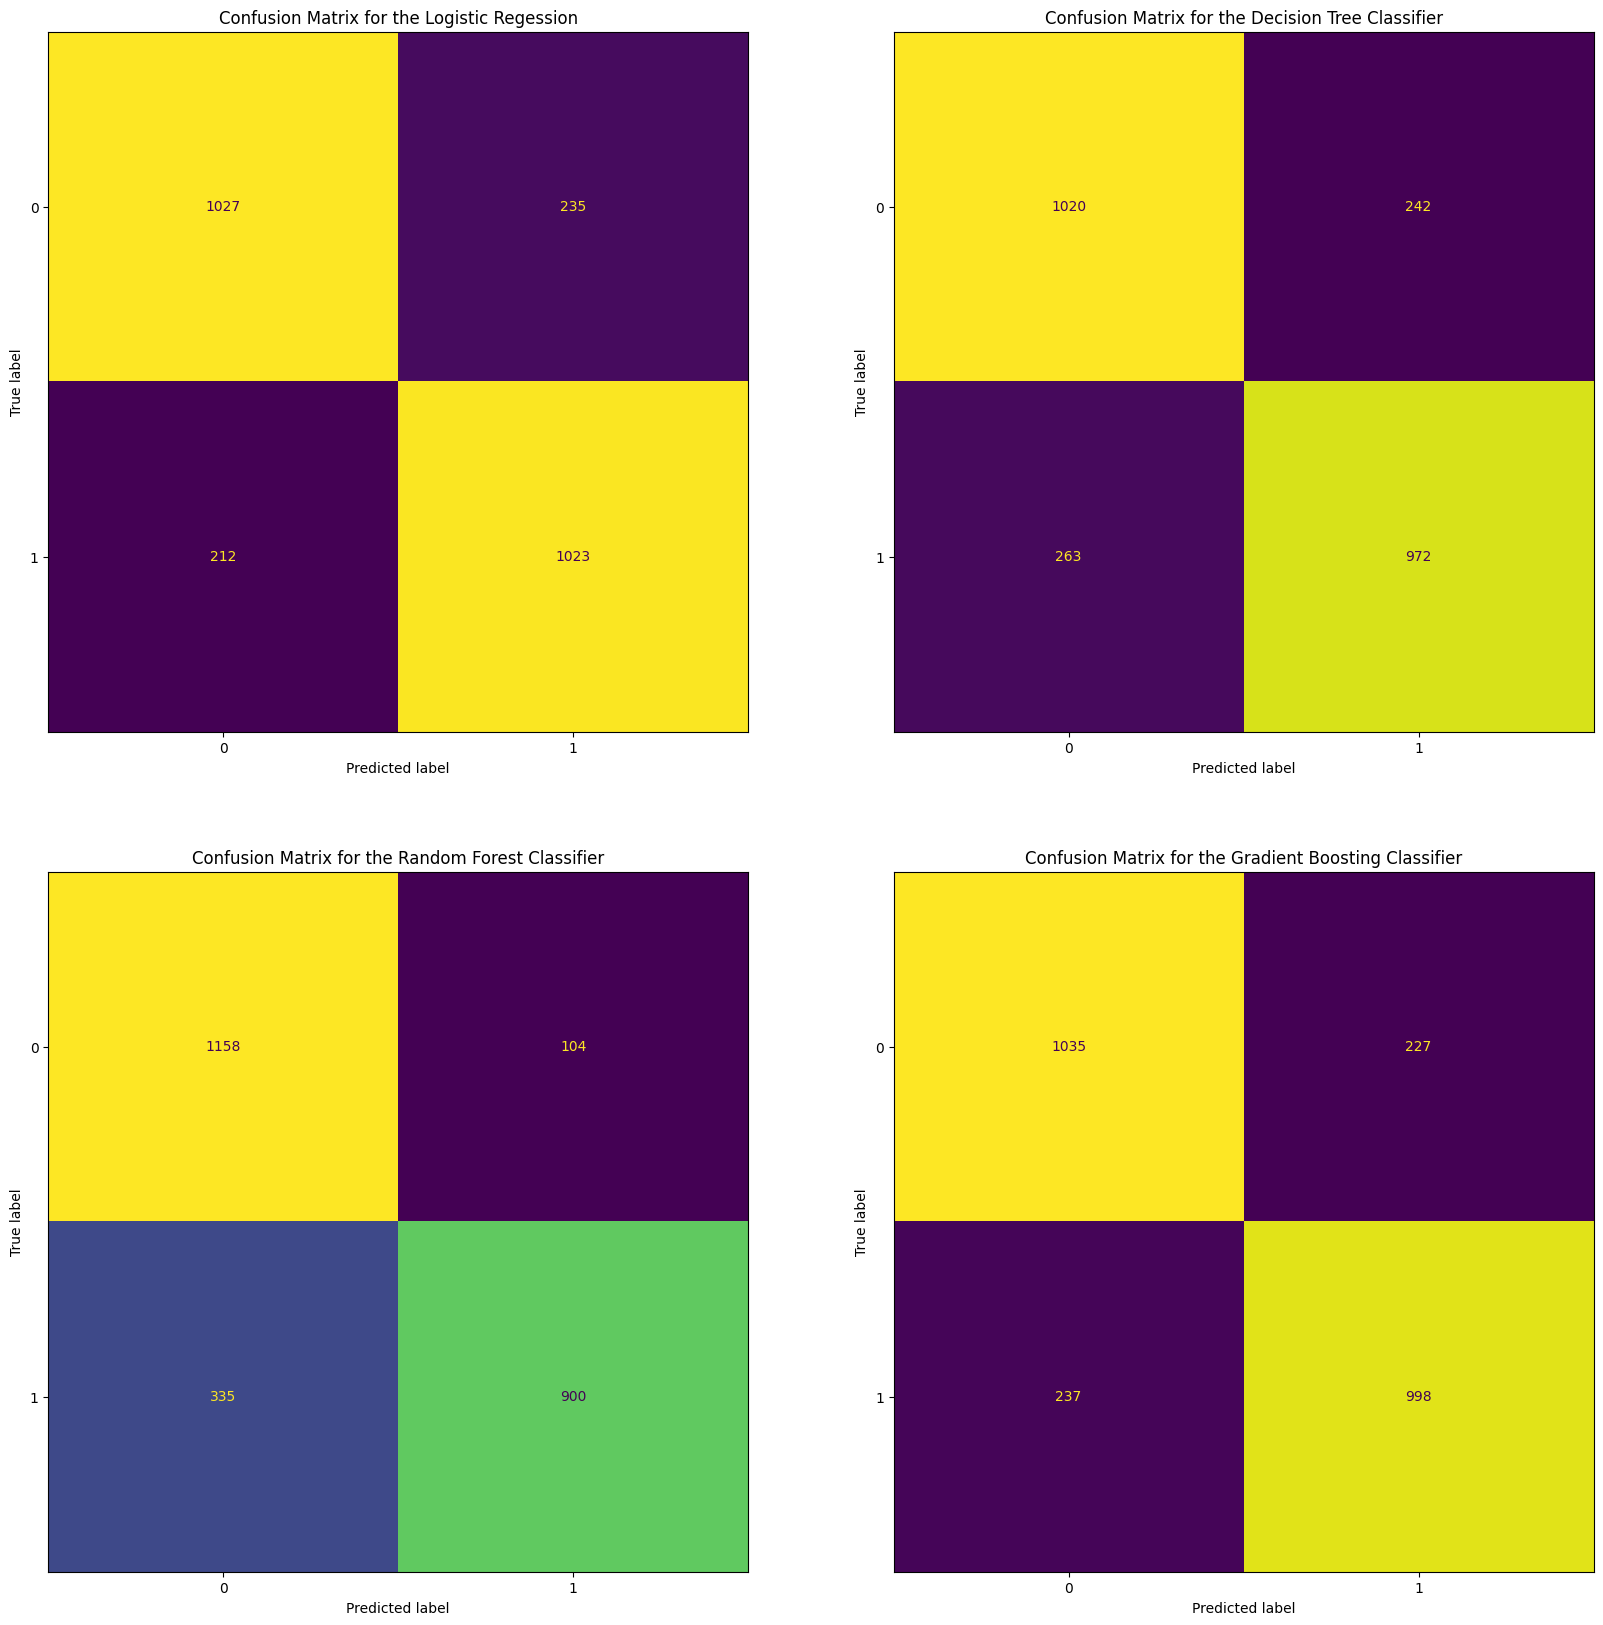

In [66]:
fig , ax = plt.subplots(2, 2, figsize = (20,20))
ConfusionMatrixDisplay.from_estimator(model_lo, X_test, y_test, colorbar= False, ax=ax[0, 0])
ConfusionMatrixDisplay.from_estimator(model_dt, X_test, y_test, colorbar= False, ax=ax[0, 1])
ConfusionMatrixDisplay.from_estimator(model.best_estimator_, X_test, y_test, colorbar= False, ax=ax[1, 0])
ConfusionMatrixDisplay.from_estimator(model_gb.best_estimator_, X_test, y_test, colorbar= False, ax=ax[1, 1])
ax[0, 0].set_title("Confusion Matrix for the Logistic Regession")
ax[0, 1].set_title("Confusion Matrix for the Decision Tree Classifier")
ax[1, 0].set_title("Confusion Matrix for the Random Forest Classifier")
ax[1, 1].set_title("Confusion Matrix for the Gradient Boosting Classifier")

<Axes: title={'center': 'Feature Importance for the Gradient Boosting Algorithm'}, xlabel='Gini Importance'>

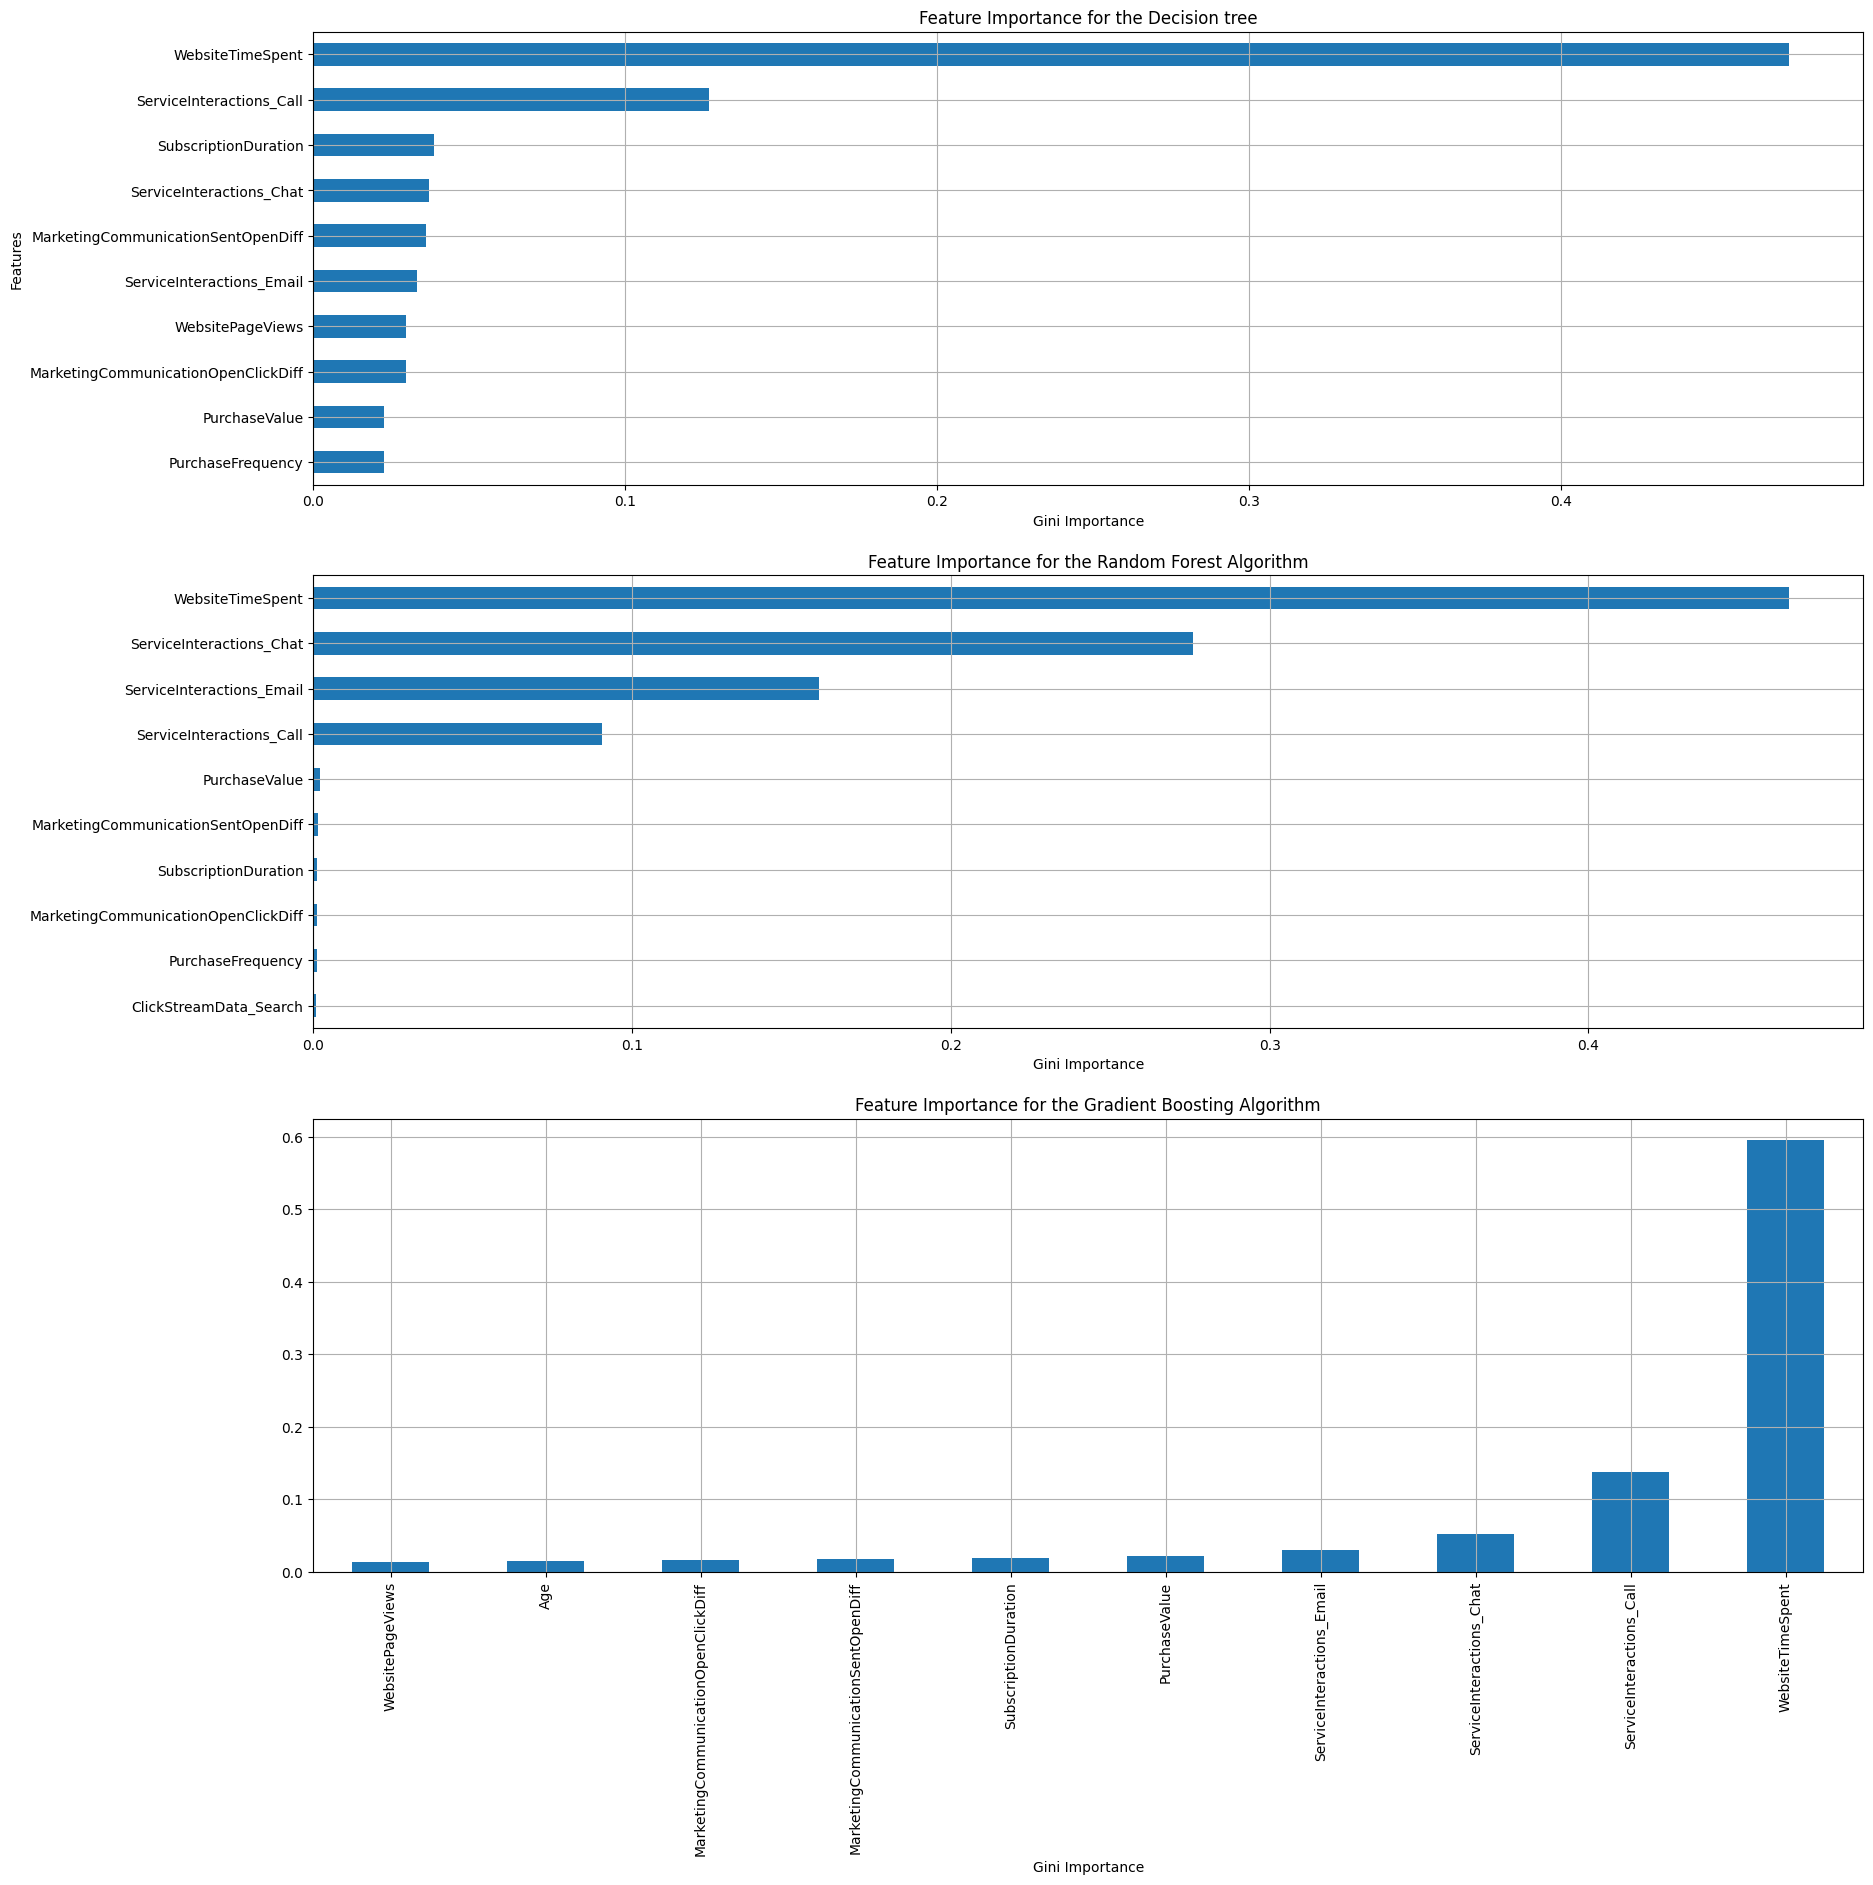

In [67]:
fig, ax = plt.subplots(3,1, figsize = (20, 20))

feat_imp_dt.sort_values().tail(10).plot(kind = "barh", 
                               xlabel = "Gini Importance", 
                               ylabel = "Features",
                               grid = True,
                               title = "Feature Importance for the Decision tree",
                               ax = ax[0])
feat_imp_rf.sort_values().tail(10).plot(kind = "barh", xlabel = "Gini Importance", grid = True, 
                                        title = "Feature Importance for the Random Forest Algorithm", 
                                        ax = ax[1])
feat_imp_gb.sort_values().tail(10).plot(kind = "bar", xlabel = "Gini Importance", grid = True,
                                        title = "Feature Importance for the Gradient Boosting Algorithm", 
                                        ax = ax[2])

From the feature importances, the parameters that are most important in determining whether or not a customer will churn are:
- the number of Service Interactions the customer has had with customer service through Call, Email and Chat,
- the time spent on the company's website,


## Let us look at a task scenario

You work for Redcom telecommunications company. Customers leaving the service can significantly impact the company's profitability, as acquiring a new customer costs 5 times more than retaining an existing one.

Your Objective:
You want to build a machine learning model to predict which customers are at risk of churning so the company can intervene with retention offers, such as discounts, loyalty benefits, or better service packages.

**Cost Implications:**
1. Cost of False Positives (Targeting Non-Churners):
Sending retention offers to customers who are not actually planning to leave costs the company $100 per customer. This includes marketing materials, discounts, and administrative costs.

2. Cost of False Negatives (Missing Churners):
Failing to identify a customer who is about to churn leads to a $2,000 loss per customer. This includes the lost revenue from their monthly subscriptions and the high cost of acquiring new customers to replace them.

**Additional Details:**
1. Each churner correctly identified and retained contributes a profit of $3000.

2. The company can only afford to spend $100,000 on retention campaigns per year, so resources must be allocated wisely.

Firstly, Let's define success criteria for Your Model

1. Minimize Costs:
We want a model that reduces the overall cost of churn, which includes the costs of false positives and false negatives.

2. Prioritize Recall:
Missing a churner (false negative) is much more expensive (€2,000 loss) than targeting a non-churner (€100 cost).

3. Balance Precision and Recall:
Although high recall is important, you need decent precision to ensure that your retention campaigns don’t exceed the allocated budget.

In [68]:
#choosing a model out of the four models that can effectively catch churners by looking at the confusion matrices and classiication reports
#logistic regression seems to have the lowest false negatives and highest churners
def make_cnf_matrix(threshold):
    y_pred_proba = model_lo.predict_proba(X_test)[:,-1]
    y_pred = y_pred_proba > threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    major_loss = fn * 2000
    campaign_cost = fp * 100
    profit = tp * 3000
    net_revenue = profit - (major_loss + campaign_cost)
    print(f" The Net Revenue is ${net_revenue}")
    print(f" The Profit gotten from retaining customers is ${profit}")
    print(f" The loss from customer churn is ${major_loss}")
    if campaign_cost <= 100_000:
        print(f" The cost from trying to retain customers that don't want to churn is ${campaign_cost}")
    else:
        print("Retention Campaign exceeds the $100000 Budget")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar= False)
thresh_widget = widgets.FloatSlider(min = 0, max = 1, value = 0.5, step = 0.01)
interact(make_cnf_matrix, threshold = thresh_widget);

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

By tuning our slider 0.03 is our optimal threshold